In [3]:
#| default_exp feat_imp

In [1]:
#| export
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score
import random

from modules.one_hot_svm import *
from modules.kmer_svm import *

In [2]:
import matplotlib.pyplot as plt
from torch import tensor
import torch
import pickle

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.frozen import FrozenEstimator

from joblib import dump, load
from scipy.stats import ks_2samp

In [2]:
model = load('ctcf_cal_unscaled_linear_svm.joblib')

In [3]:
model

,estimator,FrozenEstimat...ng='roc_auc'))
,method,'sigmoid'
,cv,None
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.0001
,C,0.01
,multi_class,'ovr'


In [4]:
test = pd.read_csv('ctcf_ml_datasets/test_dinuc.tsv', sep='\t', header=None)
test

,0,1,2,3,4
0,GGCCTGCAAAATATCCTGTAACTCCTCTAGAGGGTGCTCACTAGCA...,1,chr20,209112,209162
1,GTGCCAGTCTCTACCGCCATCTGCCGGCAGCACTCGGTACACCCGC...,1,chr20,267130,267180
2,GCCAGCGTCTCGGTCTCCAAGGAAACGCGACGCCGCCTACCGAGCG...,1,chr20,290750,290800
3,TGGGGTCTCTGGGGCCACCTAGTGGCTAAGAGGAGTAGAACCAAGG...,1,chr20,330740,330790
4,gAGGCGTCATCTCTCTTCTGTACCACTAGAGGGAGCTCTGATGCAG...,1,chr20,354618,354668
...,...,...,...,...,...
795,AAGCCAAGGTGTAGCACCCCGGGTCAATATGCTGATAACCAATTGC...,0,chrX,14039481,14039531
796,TCAGACGTGCATGGCACCAGTGAGCCGCAGGTGAACAGATGTTCTG...,0,chrX,14095821,14095871
797,CTCCCGCTGTTTGAGAATTGGAGCCATGAACAGGAGCAAAGAAGGC...,0,chrX,14528864,14528914
798,ACCTTTACAGGCTGTCTGCACCCTCCTATGTGATACTGCCTGGGCA...,0,chrX,14697644,14697694


In [5]:
with open('train_kmer_idx.pkl', 'rb') as pkl_file:
    train_kmer_idx = pickle.load(pkl_file)

In [6]:
test_seqs = [seq.upper() for seq in test[0]]
x_test_k = kmer_matrix(test_seqs, train_kmer_idx)
x_test_enc = one_hot(test_seqs)
x_test = np.hstack([x_test_k,x_test_enc])
y_test = np.array(test[1])
x_test.shape, y_test.shape, y_test[:10]

((800, 4293), (800,), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

## Feature importance

### Which were more informative, one-hot encoded base position or k-mers?

In [7]:
#| export
def block_permute(model, x_test, y_test, n=3):
    for name, start_idx, end_idx in [("onehot", 0, 200), ("kmers", 200, 4093)]:
        drops = np.zeros(n)
        for i in range(n):
            auc_base = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

            permuted = x_test.copy()
            idx = np.random.permutation(len(x_test))
            permuted[:, start_idx:end_idx] = x_test[idx, start_idx:end_idx]

            auc_shuf = roc_auc_score(y_test, model.predict_proba(permuted)[:,1])
            drops[i] = (auc_base - auc_shuf)
        print(f"{name}: avg drop {drops.mean():.4f}")

In [8]:
block_permute(model, x_test, y_test, n=5)

onehot: avg drop 0.0003
kmers: avg drop 0.3158


In [9]:
w = [
    cc.estimator.best_estimator_.coef_.ravel()
    for cc in model.calibrated_classifiers_
][0]

In [10]:
L = 50
w_pos  = w[:4*L]
w_kmer = w[4*L:]

W_pos = w_pos.reshape(L, 4).T

In [11]:
pos_importance = np.linalg.norm(W_pos, axis=0)
pos_importance

array([0.09179456, 0.06556496, 0.09961407, 0.04800838, 0.12574909,
       0.13946526, 0.05837108, 0.07715686, 0.11051119, 0.10086902,
       0.06299683, 0.03802136, 0.08260919, 0.07042689, 0.10251611,
       0.10153499, 0.07374165, 0.12144948, 0.13417383, 0.07763432,
       0.05691804, 0.09184396, 0.04388571, 0.11991801, 0.05579373,
       0.08617496, 0.04573943, 0.04933309, 0.105651  , 0.05967079,
       0.14842614, 0.08052274, 0.09391859, 0.06959666, 0.14473718,
       0.09190024, 0.12304891, 0.07024023, 0.05101711, 0.12568513,
       0.05836883, 0.08773616, 0.17686876, 0.07404518, 0.08569163,
       0.11418802, 0.12261182, 0.05089298, 0.09951485, 0.14648564])

In [12]:
#| export
def get_weights(model):
    return [ cc.estimator.best_estimator_.coef_.ravel()
         for cc in model.calibrated_classifiers_ ][0]

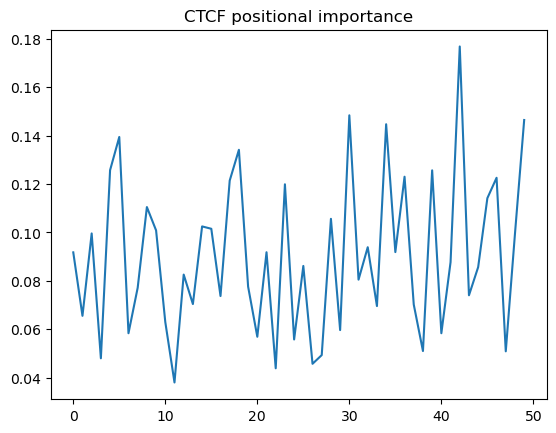

In [13]:
plt.plot(pos_importance)
plt.title("CTCF positional importance");

In [14]:
all_kmers = list(train_kmer_idx.keys())
kmer_importance = np.abs(w_kmer)
imp_idx = np.argsort(kmer_importance)[::-1]
imp_kmers = [all_kmers[i] for i in imp_idx]
imp_weights = w_kmer[imp_idx]

In [15]:
imp_kmer_list = list(zip(imp_kmers, imp_weights))
imp_kmer_list[:20]

[('ACTGAG', 0.33980194655119983),
 ('GCTGAG', -0.28333168647140833),
 ('GGAGAC', 0.26075373993850504),
 ('CAGGTT', 0.26059959864684945),
 ('CACATT', 0.2572835478433557),
 ('CAGATT', 0.22158686807489616),
 ('ATGAGG', 0.20502765240008272),
 ('CCACCC', -0.19903758377839834),
 ('CTTGAC', 0.19812896703638247),
 ('GTTAAG', 0.1936544127744985),
 ('GTTGCG', 0.19035893346454388),
 ('CAGATC', -0.1895624000498725),
 ('CGCCGG', 0.18898899572046382),
 ('ACTTAG', 0.18729970089543377),
 ('ATGTGG', 0.18722199228739783),
 ('CACGTT', 0.18074632843608218),
 ('CGCGCG', 0.1769076239168526),
 ('CCACCA', 0.17481177591605682),
 ('GAGCCC', 0.1719577392329784),
 ('GTAGAC', -0.17051397801247986)]

### Is there a CTCF motif signal in the top kmers?

In [16]:
#| export
def load_jaspar_pwm(path):
    pwm = []
    with open(path) as f:
        for line in f:
            if line.startswith(">"):
                continue
            parts = line.strip().split('[')[1].strip(']').split()
            counts = list(map(float, parts[1:]))
            pwm.append(counts)
    pwm = np.array(pwm)          
    pwm = pwm / pwm.sum(axis=0)  
    return pwm

In [17]:
pwm = load_jaspar_pwm('MA0139.1.jaspar')
pwm = pwm.T

In [18]:
#| export
def pwm_score(kmer, pwm, start):
    base_to_idx = {'A':0, 'C':1, 'G':2, 'T':3}
    score = 0.0
    for i, base in enumerate(kmer):
        score += pwm[start + i, base_to_idx[base]]
    return score

In [19]:
#| export
def best_pwm_score(kmer, pwm):
    L = pwm.shape[0]
    k = len(kmer)
    best = -np.inf

    for seq in [kmer, revcomp(kmer)]:
        for start in range(L - k + 1):
            best = max(best, pwm_score(seq, pwm, start))
    return best

In [20]:
kmer_scores = {k:best_pwm_score(k, pwm) for k in imp_kmers}
len(kmer_scores)

4093

In [21]:
top_kmers = [k for k in imp_kmers[:50]]

In [22]:
observed = np.mean([kmer_scores[k] for k in top_kmers])
observed

3.1835110504724735

In [23]:
#| export
def get_background_dist(all_kmers, n_samp, kmer_scores, n_iter=10000):
    rng = np.random.default_rng()
    null_stats = []
    for _ in range(n_iter):
        sampled = rng.choice(all_kmers, size=n_samp, replace=False)
        stat = np.mean([kmer_scores[k] for k in sampled])
        null_stats.append(stat)
    return np.array(null_stats)

In [25]:
bg_scores = get_background_dist(all_kmers, 50, kmer_scores)

In [30]:
# one-sided p-value (are top kmers more motif-like?)
p_value = (np.sum(bg_scores >= observed) + 1) / (10000 + 1)

print(f"Observed mean score: {observed:.3f}")
print(f"Null mean ± std: {bg_scores.mean():.3f} ± {bg_scores.std():.3f}")
print(f"P-value: {p_value:.3e}")

Observed mean score: 3.184
Null mean ± std: 3.114 ± 0.070
P-value: 1.618e-01


In [4]:
import nbdev.export as nb
nb.nb_export('02_kmer_svm.ipynb', './modules')